# Machine Learning aided Record Linkage - a comparison between different methods

## Group Components
* **Francesco Porto** f.porto2@campus.unimib.it (816042)
* **Francesco Stranieri** f.stranieri1@campus.unimib.it (816551)
* **Mattia Vincenzi** m.vincenzi14@campus.unimib.it (860579)

## Abstract
Record Linkage is the process of finding records in one or more datasets that refer to the same entity across different data sources. Traditionally, it is done by applying comparison rules between pairs of attributes from each dataset. In this project we investigate some possible Machine Learning applications to Record Linkage (and Data deduplication), and we compare them to the deterministic approach.

## Python Record Linkage Toolkit
Throughout the project, we make use of a Python library called ["Python Record Linkage Toolkit"](https://github.com/J535D165/recordlinkage/blob/master/docs/index.rst), which provides a simple framework to facilitate the process of Record Linkage. In the context of this library, the Record Linkage process is divided into 5 steps:

* **Preprocessing**: clean the datasets in order to improve the chances of finding matches
* **Indexing**: create pairs of records, called candidate links, from each dataset 
* **Comparison**: compare record pairs via different algorithms, thresholds, etc.
* **Classification**: classify record pairs into matches or non-matches
* **Evaluation**: evaluate classification results

In [47]:
!pip install recordlinkage
import recordlinkage as rl

### Helper Functions
We have defined a few helper functions that allow us to streamline the Record Linkage process:
- **Indexing_dataset** : given two datasets, returns the result of the indexing process (either *full* or *block*) on the given attributes

In [48]:
from recordlinkage.index import Block, Full

def indexing_dataset(dataset1, dataset2, parameters, method = 'block'):
    
    """
    Parameters
    ----------
    dataset1 : pandas.dataframe
        The dataframe containing the first dataset
    dataset2 : pandas.dataframe
        The dataframe containing the second dataset
    parameters : list
        The list of parameters to use for blocking
    method : object
        Method used for Indexing (default = 'block').
    Returns
    ----------
    candidate_links : list
        The list containing all the candidate links
    """
    
    indexer = rl.Index()
    
    if method == 'block':
        for parameter in parameters:
            indexer.add(Block(parameter))
    else:
        indexer.add(Full())
        
    if dataset2 is None:
        candidate_links = indexer.index(dataset1)
    else: 
        candidate_links = indexer.index(dataset1, dataset2)
    
    return candidate_links

- **Compare_records** : given two datasets, a set of rules specifying how to compare some attributes, and a list of attributes that must match exactly, returns a multi index containing the comparisons' results.

In [49]:
from recordlinkage.compare import Exact, String

# Only works for datasets that have the same column names
def compare_records(candidate_links, dataset1, dataset2, string_comparison, exact_match):
    
    """
    Parameters
    ----------
    candidate_links : list
        The list of candidate links
    dataset1 : pandas.dataframe
        The dataframe containing the first dataset
    dataset2 : pandas.dataframe
        The dataframe containing the second dataset
    string_comparison : dictionary
        A dictionary having as key an attribute, and as value a list of length 2 like this [method_to_use, threshold]
    exact_match : list
        A list of attributes that must match exactly
        
    Returns
    ----------
    features : pandas.MultiIndex
        A dataframe containing 1 if attributes match, and 0 if they do not
    """
    
    comparer = rl.Compare()
    
    for attribute in string_comparison.keys():
        method_comp, threshold_comp = string_comparison[attribute]
        comparer.add(String(attribute, attribute, 
                            method = method_comp, 
                            threshold = threshold_comp,
                            label = attribute))
    
    for attribute in exact_match:
        comparer.exact(attribute, attribute,
                       label = attribute)
    
    if dataset2 is None:
        features = comparer.compute(candidate_links,
                                dataset1)
    else:
        features = comparer.compute(candidate_links,
                                dataset1, dataset2)
    return features

- **Evaluate_results** : returns a confusion matrix of a given classification method; also returns its precision, f-score and recall

In [50]:
def evaluate_results(true_links, links, candidate_links_len):
    
    """
    Parameters
    ----------
    true_links : list
        The list of true_links
    links : list
        The list of links returned from the chosen model
    candidate_links_len : integer
        The length of candidate_links
        
    Returns
    ----------
    cm : numpay.ndarray
        The confusion matrix
    fscore : float
        The fscore derived from the confusion matrix
    recall : float
        The recall derived from the confusion matrix
    precision : float
        The precision derived from the confusion matrix
    """
    
    cm = rl.confusion_matrix(true_links, links, candidate_links_len)
    fscore = rl.fscore(cm)
    recall = rl.recall(cm)
    precision = rl.precision(cm)
    
    return cm, fscore, recall, precision
    

# Chapter 1: Record Linkage
In this chapter we present two examples of Record Linkage, the first one using a **Full Index**, that is we make the cartesian product of the records in the first dataset and the records in the second one; the second one uses **Blocking**, a more optimal approach that only finds a subset of the cartesian product.

## Experiment 1: Using a Full index

### Dataset description
We use the FEBRL (Freely Extensible Biomedical Record Linkage) dataset since it provides the *true links* for optimal Record Linkage. The paper used as reference is available [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.481.8577&rep=rep1&type=pdf).

In [51]:
from recordlinkage.datasets import load_febrl4

This dataset contains 10000 records (5000 originals and 5000 duplicates, with one duplicate per original); the originals have been split from the duplicates into dataset4a.csv (containing the 5000 original records) and dataset4b.csv (containing the 5000 duplicate records).

In [52]:
# load datasets
print('Loading data...')
dfA, dfB, true_links = load_febrl4(return_links = True)
print(len(dfA), 'records in dataset A')
print(len(dfB), 'records in dataset B')
print(len(true_links), 'links between dataset A and B')

Loading data...
5000 records in dataset A
5000 records in dataset B
5000 links between dataset A and B


We take a first look at the dataset. It contains auto-generated records about patients. There are 11 fields:
- **rec_id**: the id of the record
- **given_name**: the name of the patient
- **street_number**: the street number of the patient's house
- **address_1**: the road where the patient lives
- **address_2**: the city where the patient lives
- **suburb**: the suburb in the city where the patient lives
- **postcode**: the postcode of the city where the patient lives
- **state**: the state where the patient lives
- **date_of_birth**: the date of birth of the patient
- **soc_sec_id**: the social security number of the patient

In [53]:
dfA

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
...,...,...,...,...,...,...,...,...,...,...
rec-2153-org,annabel,grierson,97,mclachlan crescent,lantana lodge,broome,2480,nsw,19840224,7676186
rec-1604-org,sienna,musolino,22,smeaton circuit,pangani,mckinnon,2700,nsw,19890525,4971506
rec-1003-org,bradley,matthews,2,jondol place,horseshoe ck,jacobs well,7018,sa,19481122,8927667


In [54]:
dfA.dtypes

given_name       object
surname          object
street_number    object
address_1        object
address_2        object
suburb           object
postcode         object
state            object
date_of_birth    object
soc_sec_id       object
dtype: object

In [55]:
dfB

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-561-dup-0,elton,NaN,3,light setreet,pinehill,windermere,3212,vic,19651013,1551941
rec-2642-dup-0,mitchell,maxon,47,edkins street,lochaoair,north ryde,3355,nsw,19390212,8859999
rec-608-dup-0,NaN,white,72,lambrigg street,kelgoola,broadbeach waters,3159,vic,19620216,9731855
rec-3239-dup-0,elk i,menzies,1,lyster place,NaN,northwood,2585,vic,19980624,4970481
rec-2886-dup-0,NaN,garanggar,NaN,may maxwell crescent,springettst arcade,forest hill,2342,vic,19921016,1366884
...,...,...,...,...,...,...,...,...,...,...
rec-4495-dup-0,connor,belperio,15,NaN,NaN,ryde,2570,nsw,19170518,5394641
rec-4211-dup-0,daniel,maspn,9,derrington crescent,el pedro caravan park,sunnybank,4350,vic,19500705,5525378
rec-3131-dup-0,samuel,crofs,613,banjine street,kurrajong vlge,pengzin,2230,qld,19410531,4467228


In [56]:
dfB.dtypes

given_name       object
surname          object
street_number    object
address_1        object
address_2        object
suburb           object
postcode         object
state            object
date_of_birth    object
soc_sec_id       object
dtype: object

We notice that the records having the same numeric id represent the same entity.

In [57]:
dfA.loc['rec-1070-org']

given_name             michaela
surname                 neumann
street_number                 8
address_1        stanley street
address_2                 miami
suburb            winston hills
postcode                   4223
state                       nsw
date_of_birth          19151111
soc_sec_id              5304218
Name: rec-1070-org, dtype: object

In [58]:
dfB.loc['rec-1070-dup-0']

given_name             michafla
surname                 jakimow
street_number                 8
address_1        stanleykstreet
address_2                 miami
suburb            winstonbhills
postcode                   4223
state                       NaN
date_of_birth          19151111
soc_sec_id              5304218
Name: rec-1070-dup-0, dtype: object

### Indexing (Full)
Indexing is the process of creating all the possible links, also called **candidate links**, between the two datasets. In this specific example, we use a technique called **Full Indexing**, which returns the cartesian products of the records from each dataset.

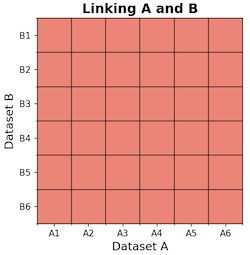

In [59]:
candidate_links_full = indexing_dataset(dfA, dfB, [], method = 'full')
candidate_links_full

MultiIndex([('rec-1070-org',  'rec-561-dup-0'),
            ('rec-1070-org', 'rec-2642-dup-0'),
            ('rec-1070-org',  'rec-608-dup-0'),
            ('rec-1070-org', 'rec-3239-dup-0'),
            ('rec-1070-org', 'rec-2886-dup-0'),
            ('rec-1070-org', 'rec-4285-dup-0'),
            ('rec-1070-org',  'rec-929-dup-0'),
            ('rec-1070-org', 'rec-4833-dup-0'),
            ('rec-1070-org',  'rec-717-dup-0'),
            ('rec-1070-org', 'rec-3984-dup-0'),
            ...
            (  'rec-66-org',  'rec-670-dup-0'),
            (  'rec-66-org', 'rec-4134-dup-0'),
            (  'rec-66-org', 'rec-3866-dup-0'),
            (  'rec-66-org', 'rec-3152-dup-0'),
            (  'rec-66-org', 'rec-3363-dup-0'),
            (  'rec-66-org', 'rec-4495-dup-0'),
            (  'rec-66-org', 'rec-4211-dup-0'),
            (  'rec-66-org', 'rec-3131-dup-0'),
            (  'rec-66-org', 'rec-3815-dup-0'),
            (  'rec-66-org',  'rec-493-dup-0')],
           names=['rec_

### Comparison
**Comparison** refers to the process of evaluating all the possible candidate links in order to figure out all the attributes having the same value. In order to compare attributes, we need to specify (for each attribute):
* A **metric** to be used for evaluating the similarity between each pair of the same attributes of the different dataset
* A **threshold** to decide under which circumstances the metric shall return 1 (the similarity is 1 in case of agreement) or 0 (in case of complete disagreement)

In this specific example we used the Jaro-Winkler method since, according to the documentation, it is faster than the Levenshtein distance and much faster than the Damerau-Levenshtein distance. Since comparing strings is computationally expensive, we chose a subset of attributes on which some errors are permitted. 

In [60]:
comparison = {'surname':['jarowinkler',0.85],
              'address_1':['jarowinkler',0.85], 
              'address_2':['jarowinkler',0.85] }
exact = ['given_name', 'date_of_birth', 'suburb', 'state']

features_full = compare_records(candidate_links_full, dfA, dfB, comparison, exact)
features_full

surname  address_1  address_2  given_name  \
rec_id_1     rec_id_2                                                    
rec-1070-org rec-561-dup-0       0.0        0.0        0.0           0   
             rec-2642-dup-0      0.0        0.0        0.0           0   
             rec-608-dup-0       0.0        0.0        0.0           0   
             rec-3239-dup-0      0.0        0.0        0.0           0   
             rec-2886-dup-0      0.0        0.0        0.0           0   
...                              ...        ...        ...         ...   
rec-66-org   rec-4495-dup-0      0.0        0.0        0.0           0   
             rec-4211-dup-0      0.0        0.0        0.0           0   
             rec-3131-dup-0      0.0        0.0        0.0           0   
             rec-3815-dup-0      0.0        0.0        0.0           0   
             rec-493-dup-0       0.0        0.0        0.0           0   

                             date_of_birth  suburb  state  
rec_id_1     rec_id_2                                      
rec-1070-org rec-561-dup-0               0       0      0  
             rec-2642-dup-0              0       0      1  
             rec-608-dup-0               0       0      0  
             rec-3239-dup-0              0       0      0  
             rec-2886-dup-0              0       0      0  
...                                    ...     ...    ...  
rec-66-org   rec-4495-dup-0              0       0      1  
             rec-4211-dup-0              0       0      0  
             rec-3131-dup-0              0       0      0  
             rec-3815-dup-0              0       0      0  
             rec-493-dup-0               0       0      0  

[25000000 rows x 7 columns]

**Note**: no cardinality reduction is employed. The output of indexing phase has the same cardinality of the comparison phase. The columns represent the results of the comparison.

### Classification
In this phase, candidate links are classified into matches or non-matches. We analyze 3 different classification methods:
- **Deterministic approach** (no Machine Learning used)
- **Naive Bayes** (Supervised Learning)
- **Expectation-Conditional Maximisation** (Unsupervised Learning)

#### Deterministic approach

In the deterministic approach, we consider all the records that agree on at least a certain amount of attributes according to the rules we have previously specified.

In [61]:
# Sum the comparison results.
features_full.sum(axis=1).value_counts().sort_index(ascending=False)

7.0        1304
6.0        1860
5.0        1260
4.0         441
3.0         452
2.0       69727
1.0     5634539
0.0    19290417
dtype: int64

We notice that 1304 records have 7 common attributes, according to the comparison metrics that we chose. 1860 records have 6 common attributes instead, and so on.

In [62]:
# Percentage of the comparison results.
(features_full.sum(axis=1).value_counts() / len(candidate_links_full) * 100).sort_index(ascending=False) 

7.0     0.005216
6.0     0.007440
5.0     0.005040
4.0     0.001764
3.0     0.001808
2.0     0.278908
1.0    22.538156
0.0    77.161668
dtype: float64

We consider a match all the pairs that agree on at least 4 attributes. In the following table, the matches according to this rule are shown.

In [63]:
links_noml_full = features_full[features_full.sum(axis=1) >= 4]
links_noml_full

,,surname,address_1,address_2,given_name,date_of_birth,suburb,state
rec_id_1,rec_id_2,,,,,,,
rec-1016-org,rec-1016-dup-0,1.0,1.0,0.0,1,1,1,0
rec-4405-org,rec-4405-dup-0,1.0,1.0,1.0,1,1,1,1
rec-1288-org,rec-1288-dup-0,1.0,1.0,1.0,1,1,0,1
rec-3585-org,rec-3585-dup-0,1.0,1.0,1.0,1,1,1,1
rec-298-org,rec-298-dup-0,1.0,0.0,0.0,1,1,1,1
...,...,...,...,...,...,...,...,...
rec-2153-org,rec-2153-dup-0,1.0,0.0,0.0,0,1,1,1
rec-1604-org,rec-1604-dup-0,0.0,1.0,1.0,0,1,1,1
rec-1003-org,rec-1003-dup-0,0.0,1.0,1.0,0,1,0,1


#### Naive Bayes
Naive Bayes is a supervised-learning algorithm that provides a method for computing the probability of a given hypotesis on prior knowledge. It is based on the assumption that all features are conditionally independent.

We initialise the NaiveBayesClassifier.

In [64]:
nb_full = rl.NaiveBayesClassifier()
nb_full.fit(features_full, true_links)

We print also the parameters that are trained.
- p is the probability P(Match)
- m is the probability that P(x_i=1|Match)
- u is the probability that P(x_i=1|Non-Match)

In [65]:
print("p probability P(Match):", nb_full.p)
print()
print("m probabilities P(x_i=1|Match):", nb_full.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", nb_full.u_probs)
print()
print("weights of features:", nb_full.weights)

p probability P(Match): 0.00019999999999999985

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.14700001411999955, 1.0: 0.8529999858800007}, 'address_1': {0.0: 0.11280001548799944, 1.0: 0.8871999845120011}, 'address_2': {0.0: 0.23020001079199967, 1.0: 0.7697999892080011}, 'given_name': {0.0: 0.3426000062959999, 1.0: 0.6573999937040006}, 'date_of_birth': {0.0: 0.10620001575199943, 1.0: 0.8937999842480008}, 'suburb': {0.0: 0.25420000983199964, 1.0: 0.7457999901680004}, 'state': {0.0: 0.05860001765599933, 1.0: 0.9413999823440014}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 0.9951189437847974, 1.0: 0.004881056215203998}, 'address_1': {0.0: 0.9971519903941033, 1.0: 0.0028480096058983977}, 'address_2': {0.0: 0.9987709141788471, 1.0: 0.0012290858211543999}, 'given_name': {0.0: 0.9970409281816627, 1.0: 0.002959071818339998}, 'date_of_birth': {0.0: 0.9999744748909813, 1.0: 2.5525109021600138e-05}, 'suburb': {0.0: 0.9991115823124727, 1.0: 0.0008884176875304002}, 'state': {0.0: 0.

We tried to predict the matches starting by the output of the comparison phase, using the trained model. We know from the documentation that the total matches are 5000 and our model found 4958.

In [66]:
# Evaluate the model
links_bayes_full = nb_full.predict(features_full)
print("Predicted number of links:", len(links_bayes_full))

Predicted number of links: 4958


We predict the match probability for each pair in the dataset, since we apply the Full index method.

In [67]:
probs_bayes_full = nb_full.prob(features_full)
probs_bayes_full

rec_id_1      rec_id_2      
rec-1070-org  rec-561-dup-0     5.362010e-10
              rec-2642-dup-0    3.086106e-08
              rec-608-dup-0     5.362010e-10
              rec-3239-dup-0    5.362010e-10
              rec-2886-dup-0    5.362010e-10
                                    ...     
rec-66-org    rec-4495-dup-0    3.086106e-08
              rec-4211-dup-0    5.362010e-10
              rec-3131-dup-0    5.362010e-10
              rec-3815-dup-0    5.362010e-10
              rec-493-dup-0     5.362010e-10
Length: 25000000, dtype: float64

#### Expectation-Conditional Maximisation
Unsupervised learning with the ECM algorithm. This classifier doesn’t need training data since it is often hard to collect.

We initialise the Expectation-Conditional Maximisation classifier.

In [68]:
ecm_full = rl.ECMClassifier()
ecm_full.fit(features_full)

We print the parameters that are trained (m, u and p).

In [69]:
print("p probability P(Match):", ecm_full.p)
print()
print("m probabilities P(x_i=1|Match):", ecm_full.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", ecm_full.u_probs)
print()
print("weights of features:", ecm_full.weights)

p probability P(Match): 0.00019964038993562045

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.14559845395438062, 1.0: 0.8544015460456198}, 'address_1': {0.0: 0.11167423011028436, 1.0: 0.8883257698897149}, 'address_2': {0.0: 0.22930633589775026, 1.0: 0.7706936641022502}, 'given_name': {0.0: 0.3415113651654586, 1.0: 0.6584886348345418}, 'date_of_birth': {0.0: 0.10497269467212568, 1.0: 0.8950273053278734}, 'suburb': {0.0: 0.25371788422318436, 1.0: 0.7462821157768156}, 'state': {0.0: 0.05893559457665887, 1.0: 0.9410644054233418}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 0.9951189185968193, 1.0: 0.0048810814031804844}, 'address_1': {0.0: 0.9971518971067167, 1.0: 0.002848102893281545}, 'address_2': {0.0: 0.9987708161888874, 1.0: 0.0012291838111130658}, 'given_name': {0.0: 0.9970409101739776, 1.0: 0.0029590898260201783}, 'date_of_birth': {0.0: 0.9999743984891409, 1.0: 2.5601510856925678e-05}, 'suburb': {0.0: 0.9991114106542701, 1.0: 0.0008885893457278089}, 'state': {0.0: 0

In [70]:
# evaluate the model
links_ecm_full = ecm_full.predict(features_full)
print("Predicted number of links:", len(links_ecm_full))

Predicted number of links: 4958


In [71]:
# Predict the match probability for each pair in the dataset.
probs_ecm_full = ecm_full.prob(features_full)
print(probs_ecm_full)

rec_id_1      rec_id_2      
rec-1070-org  rec-561-dup-0     5.170889e-10
              rec-2642-dup-0    2.958100e-08
              rec-608-dup-0     5.170889e-10
              rec-3239-dup-0    5.170889e-10
              rec-2886-dup-0    5.170889e-10
                                    ...     
rec-66-org    rec-4495-dup-0    2.958100e-08
              rec-4211-dup-0    5.170889e-10
              rec-3131-dup-0    5.170889e-10
              rec-3815-dup-0    5.170889e-10
              rec-493-dup-0     5.170889e-10
Length: 25000000, dtype: float64


### Evaluation
We compare the results of the deterministic method and the two ML-based ones (Naive Bayes and ECM)

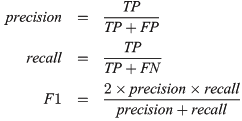

In [72]:
cm_noml_full, fscore_noml_full, recall_noml_full, precision_noml_full = evaluate_results(true_links, 
                                                                                         links_noml_full, 
                                                                                         len(candidate_links_full))
print("Deterministic approach \n")
print('Confusion matrix: \n', cm_noml_full)
print('Fscore:',fscore_noml_full)
print('Recall:',recall_noml_full)
print('Precision:',precision_noml_full)

Deterministic approach 

Confusion matrix: 
 [[    4865      135]
 [       0 24995000]]
Fscore: 0.9863152559553979
Recall: 0.973
Precision: 1.0


In [73]:
cm_nb_full, fscore_nb_full, recall_nb_full, precision_nb_full = evaluate_results(true_links, 
                                                                                 links_bayes_full, 
                                                                                 len(candidate_links_full))
print("Naive Bayes \n")
print('Confusion matrix: \n', cm_nb_full)
print('Fscore:', fscore_nb_full)
print('Recall:', recall_nb_full)
print('Precision:', precision_nb_full)

Naive Bayes 

Confusion matrix: 
 [[    4954       46]
 [       4 24994996]]
Fscore: 0.9949789114279977
Recall: 0.9908
Precision: 0.9991932230738201


In [74]:
cm_ecm_full, fscore_ecm_full, recall_ecm_full, precision_ecm_full = evaluate_results(true_links, 
                                                                                     links_ecm_full, 
                                                                                     len(candidate_links_full))
print("Expectation-Conditional Maximisation \n")
print('Confusion matrix: \n', cm_ecm_full)
print('Fscore:',fscore_ecm_full)
print('Recall:',recall_ecm_full)
print('Precision:',precision_ecm_full)

Expectation-Conditional Maximisation 

Confusion matrix: 
 [[    4954       46]
 [       4 24994996]]
Fscore: 0.9949789114279977
Recall: 0.9908
Precision: 0.9991932230738201


## Experiment 2 : Using a Block index

### Indexing (Block)
Indexing is the process of creating all the possible links between the two datasets. In this specific example, we use a technique called **Blocking**, which groups together all the records that agree on AT LEAST one of the specified attributes.

We have decided to use **surname**, **date_of_birth** and **soc_sec_id** as discriminating variables. By doing that, the resulting records will agree on at least one of these attributes.

**Note**: the cardinality using the Block index method is way less than the Full index method. 

In [75]:
candidate_links_block = indexing_dataset(dfA, dfB, ['surname', 'date_of_birth', 'soc_sec_id'])
candidate_links_block

MultiIndex([(  'rec-0-org',    'rec-0-dup-0'),
            (  'rec-0-org', 'rec-1505-dup-0'),
            (  'rec-0-org', 'rec-1636-dup-0'),
            (  'rec-0-org', 'rec-2074-dup-0'),
            (  'rec-0-org', 'rec-2683-dup-0'),
            (  'rec-0-org', 'rec-2724-dup-0'),
            (  'rec-0-org', 'rec-2894-dup-0'),
            (  'rec-1-org',    'rec-1-dup-0'),
            (  'rec-1-org', 'rec-1052-dup-0'),
            (  'rec-1-org', 'rec-2552-dup-0'),
            ...
            ('rec-999-org', 'rec-3685-dup-0'),
            ('rec-999-org',  'rec-370-dup-0'),
            ('rec-999-org', 'rec-3766-dup-0'),
            ('rec-999-org', 'rec-3862-dup-0'),
            ('rec-999-org', 'rec-3913-dup-0'),
            ('rec-999-org', 'rec-3940-dup-0'),
            ('rec-999-org', 'rec-4941-dup-0'),
            ('rec-999-org',  'rec-859-dup-0'),
            ('rec-999-org',  'rec-911-dup-0'),
            ('rec-999-org',  'rec-999-dup-0')],
           names=['rec_id_1', 'rec_id_2'], 

We verify that a pair of candidate links agree on the given attributes:

In [76]:
dfA.loc[candidate_links_block[0][0]]

given_name               rachael
surname                     dent
street_number                  1
address_1            knox street
address_2        lakewood estate
suburb                    byford
postcode                    4129
state                        vic
date_of_birth           19280722
soc_sec_id               1683994
Name: rec-0-org, dtype: object

In [77]:
dfB.loc[candidate_links_block[0][1]]

given_name               rachael
surname                     dent
street_number                  4
address_1            knox street
address_2        lakewood estate
suburb                    byford
postcode                    4129
state                        vic
date_of_birth           19280722
soc_sec_id               1683994
Name: rec-0-dup-0, dtype: object

### Comparison
We used the same metrics and threshold for each pair of attributes used in the previous experiment.

In [78]:
features_block = compare_records(candidate_links_block, dfA, dfB, comparison, exact)
features_block

surname  address_1  address_2  given_name  \
rec_id_1    rec_id_2                                                    
rec-0-org   rec-0-dup-0         1.0        1.0        1.0           1   
            rec-1505-dup-0      1.0        0.0        0.0           0   
            rec-1636-dup-0      1.0        0.0        0.0           0   
            rec-2074-dup-0      1.0        0.0        0.0           0   
            rec-2683-dup-0      1.0        0.0        0.0           0   
...                             ...        ...        ...         ...   
rec-999-org rec-3940-dup-0      1.0        0.0        0.0           0   
            rec-4941-dup-0      1.0        0.0        0.0           0   
            rec-859-dup-0       1.0        0.0        0.0           0   
            rec-911-dup-0       1.0        0.0        0.0           0   
            rec-999-dup-0       1.0        1.0        1.0           1   

                            date_of_birth  suburb  state  
rec_id_1    rec_id_2                                      
rec-0-org   rec-0-dup-0                 1       1      1  
            rec-1505-dup-0              0       0      0  
            rec-1636-dup-0              0       0      0  
            rec-2074-dup-0              0       0      1  
            rec-2683-dup-0              0       0      0  
...                                   ...     ...    ...  
rec-999-org rec-3940-dup-0              0       0      0  
            rec-4941-dup-0              0       0      0  
            rec-859-dup-0               0       0      0  
            rec-911-dup-0               0       0      1  
            rec-999-dup-0               1       1      1  

[87132 rows x 7 columns]

### Classification

#### Deterministic approach
Also in this case, we consider a match all the pairs that agree on at least 4 attributes.

In [79]:
# Sum the comparison results.
features_block.sum(axis=1).value_counts().sort_index(ascending=False)

7.0     1304
6.0     1857
5.0     1257
4.0      438
3.0      268
2.0    18304
1.0    63704
dtype: int64

In [80]:
# Percentage of the comparison results.
(features_block.sum(axis=1).value_counts() / len(candidate_links_block) * 100).sort_index(ascending=False) 

7.0     1.496580
6.0     2.131249
5.0     1.442639
4.0     0.502686
3.0     0.307579
2.0    21.007207
1.0    73.112060
dtype: float64

In [81]:
links_noml_block = features_block[features_block.sum(axis=1) >= 4]
links_noml_block

,,surname,address_1,address_2,given_name,date_of_birth,suburb,state
rec_id_1,rec_id_2,,,,,,,
rec-0-org,rec-0-dup-0,1.0,1.0,1.0,1,1,1,1
rec-1-org,rec-1-dup-0,1.0,1.0,1.0,1,1,1,1
rec-10-org,rec-10-dup-0,1.0,1.0,1.0,0,1,1,1
rec-100-org,rec-100-dup-0,1.0,1.0,1.0,1,0,1,1
rec-1000-org,rec-1000-dup-0,1.0,1.0,1.0,1,1,1,1
...,...,...,...,...,...,...,...,...
rec-995-org,rec-995-dup-0,1.0,1.0,1.0,1,1,1,1
rec-996-org,rec-996-dup-0,1.0,1.0,0.0,1,1,1,1
rec-997-org,rec-997-dup-0,1.0,1.0,1.0,1,1,1,1


#### Naive Bayes

In [82]:
# Initialise the NaiveBayesClassifier.
nb_block = rl.NaiveBayesClassifier()
nb_block.fit(features_block, true_links)

In [83]:
# Print the parameters that are trained (m, u and p).
print("p probability P(Match):", nb_block.p)
print()
print("m probabilities P(x_i=1|Match):", nb_block.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", nb_block.u_probs)
print()
print("weights of features:", nb_block.weights)

p probability P(Match): 0.05726943028967549

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.1462925993469899, 1.0: 0.8537074006530102}, 'address_1': {0.0: 0.11302606761418561, 1.0: 0.8869739323858145}, 'address_2': {0.0: 0.23026053185328524, 1.0: 0.7697394681467138}, 'given_name': {0.0: 0.34268537704667806, 1.0: 0.6573146229533218}, 'date_of_birth': {0.0: 0.10440883349062785, 1.0: 0.8955911665093714}, 'suburb': {0.0: 0.25430862708181856, 1.0: 0.7456913729181811}, 'state': {0.0: 0.05871745255641471, 1.0: 0.941282547443585}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 0.0077305166474385435, 1.0: 0.9922694833525615}, 'address_1': {0.0: 0.9970904032112915, 1.0: 0.002909596788708342}, 'address_2': {0.0: 0.9987338986176765, 1.0: 0.001266101382323047}, 'given_name': {0.0: 0.9970173589710086, 1.0: 0.002982641028992133}, 'date_of_birth': {0.0: 0.9922329612324204, 1.0: 0.007767038767580439}, 'suburb': {0.0: 0.9990382496188591, 1.0: 0.0009617503811405855}, 'state': {0.0: 0.7818777

In [84]:
# Evaluate the model
links_bayes_block = nb_block.predict(features_block)
print("Predicted number of links:", len(links_bayes_block))

Predicted number of links: 5107


In [85]:
# Predict the match probability for each pair in the dataset.
probs_bayes_block = nb_block.prob(features_block)
probs_bayes_block

rec_id_1     rec_id_2      
rec-0-org    rec-0-dup-0       1.000000e+00
             rec-1505-dup-0    9.443910e-07
             rec-1636-dup-0    9.443910e-07
             rec-2074-dup-0    5.426506e-05
             rec-2683-dup-0    9.443910e-07
                                   ...     
rec-999-org  rec-3940-dup-0    9.443910e-07
             rec-4941-dup-0    9.443910e-07
             rec-859-dup-0     9.443910e-07
             rec-911-dup-0     5.426506e-05
             rec-999-dup-0     1.000000e+00
Length: 87132, dtype: float64

#### Expectation-Conditional Maximisation

In [86]:
# Initialise the Expectation-Conditional Maximisation classifier.
ecm_block = rl.ECMClassifier()
ecm_block.fit(features_block)

In [87]:
# Print the parameters that are trained (m, u and p).
print("p probability P(Match):", ecm_block.p)
print()
print("m probabilities P(x_i=1|Match):", ecm_block.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", ecm_block.u_probs)
print()
print("weights of features:", ecm_block.weights)

p probability P(Match): 0.05890218346289975

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.17208594081201783, 1.0: 0.8279140591879811}, 'address_1': {0.0: 0.1364062789961936, 1.0: 0.863593721003806}, 'address_2': {0.0: 0.25072440372196897, 1.0: 0.7492755962780303}, 'given_name': {0.0: 0.36109752267741557, 1.0: 0.6389024773225834}, 'date_of_birth': {0.0: 0.1019492644528454, 1.0: 0.8980507355471536}, 'suburb': {0.0: 0.2754889672490091, 1.0: 0.7245110327509904}, 'state': {0.0: 0.06435714759255907, 1.0: 0.9356428524074404}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 0.00587574265639725, 1.0: 0.9941242573436027}, 'address_1': {0.0: 0.9971608673018983, 1.0: 0.002839132698101932}, 'address_2': {0.0: 0.9987863491894582, 1.0: 0.001213650810542423}, 'given_name': {0.0: 0.9970001958451015, 1.0: 0.002999804154898576}, 'date_of_birth': {0.0: 0.9939272291845378, 1.0: 0.006072770815462413}, 'suburb': {0.0: 0.9990046632627301, 1.0: 0.0009953367372699084}, 'state': {0.0: 0.78277938458

In [88]:
# evaluate the model
links_ecm_block = ecm_block.predict(features_block)
print("Predicted number of links:", len(links_ecm_block))

Predicted number of links: 5110


In [89]:
# Predict the match probability for each pair in the dataset.
probs_ecm_block = ecm_block.prob(features_block)
print(probs_ecm_block)

rec_id_1     rec_id_2      
rec-0-org    rec-0-dup-0       1.000000
             rec-1505-dup-0    0.000002
             rec-1636-dup-0    0.000002
             rec-2074-dup-0    0.000079
             rec-2683-dup-0    0.000002
                                 ...   
rec-999-org  rec-3940-dup-0    0.000002
             rec-4941-dup-0    0.000002
             rec-859-dup-0     0.000002
             rec-911-dup-0     0.000079
             rec-999-dup-0     1.000000
Length: 87132, dtype: float64


### Evaluation

In [90]:
cm_noml_block, fscore_noml_block, recall_noml_block, precision_noml_block = evaluate_results(true_links, links_noml_block, len(candidate_links_block))

print("Deterministic approach \n")
print('Confusion matrix: \n', cm_noml_block)
print('Fscore:',fscore_noml_block)
print('Recall:',recall_noml_block)
print('Precision:',precision_noml_block)

Deterministic approach 

Confusion matrix: 
 [[ 4856   144]
 [    0 82132]]
Fscore: 0.9853896103896103
Recall: 0.9712
Precision: 1.0


In [91]:
cm_nb_block, fscore_nb_block, recall_nb_block, precision_nb_block = evaluate_results(true_links, links_bayes_block, len(candidate_links_block))

print("Naive Bayes \n")
print('Confusion matrix: \n', cm_nb_block)
print('Fscore:',fscore_nb_block)
print('Recall:',recall_nb_block)
print('Precision:',precision_nb_block)

Naive Bayes 

Confusion matrix: 
 [[ 4956    44]
 [  151 81981]]
Fscore: 0.9807064410804394
Recall: 0.9912
Precision: 0.9704327393773252


In [92]:
cm_ecm_block, fscore_ecm_block, recall_ecm_block, precision_ecm_block = evaluate_results(true_links, links_ecm_block, len(candidate_links_block))

print("Expectation-Conditional Maximisation \n")
print('Confusion matrix: \n', cm_ecm_block)
print('Fscore:',fscore_ecm_block)
print('Recall:',recall_ecm_block)
print('Precision:',precision_ecm_block)

Expectation-Conditional Maximisation 

Confusion matrix: 
 [[ 4959    41]
 [  151 81981]]
Fscore: 0.9810089020771513
Recall: 0.9918
Precision: 0.9704500978473581


## Results Analysis
From the previous two experiments, we noticed that:
- The cardinality of the candidate links with Full index method is 25000000, with the Block index is 87132. 
- This leads to a significative difference in the execution time: 
    - The Full index takes 160 seconds circa for the comparison phase; the Block index takes about 0.56 seconds instead. 
    - Naive Bayes takes about 150s with Full index and 0.23s with Block index.
    - ECM takes about 92s with Full index and 0.29s with Block index.
- This does not lead to a significative difference in the evaluation results:
    - The Full index method brings a very small increase in the Fscore.  

We do not consider this result to be meaningful. Blocking should always be preferred, provided that it is clear what attributes should be used in the index.

# Chapter 2: Data Deduplication
Data Deduplication is the process of linking a dataset to itself, in order to find duplicate records.

## Experiment 3 : Creating prediction models
In this experiment, we first train our models on a smaller dataset. Then, we test the models on a bigger one with the *same* attributes but with different distribution of duplicates.

## Part 1 : Training

### Dataset description
This data set contains 5000 records (4000 originals and 1000 duplicates), with a maximum of 5 duplicates based on one original record (and a poisson distribution of duplicate records). Distribution of duplicates: 19 originals records have 5 duplicate records 47 originals records have 4 duplicate records 107 originals records have 3 duplicate records 141 originals records have 2 duplicate records 114 originals records have 1 duplicate record 572 originals records have no duplicate record.

In [93]:
from recordlinkage.datasets import load_febrl2
# load datasets
print('Loading data...')
df, true_links = load_febrl2(return_links = True)
print(len(df), 'records in dataset A')
print(len(true_links), 'links between dataset A and A')

Loading data...
5000 records in dataset A
1934 links between dataset A and A


In [94]:
df

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742
...,...,...,...,...,...,...,...,...,...,...
rec-1487-org,thomas,green,44,tuthill place,holmeleigh,bonny hills,4740,vic,19420210,9334580
rec-1856-org,james,mcneill,42,archibald street,NaN,evans head,2250,nsw,19011207,4837378
rec-3307-org,paige,lock,7,a'beckett street,camboon,carina heights,2290,nsw,19871002,5142242


In [95]:
df.dtypes

given_name       object
surname          object
street_number    object
address_1        object
address_2        object
suburb           object
postcode         object
state            object
date_of_birth    object
soc_sec_id       object
dtype: object

We notice that the records having the same numeric id represent the same entity but with some errors in various attributes.

In [96]:
df.loc['rec-712-org']

given_name                    jacob
surname                      lanyon
street_number                     5
address_1                milne cove
address_2                  wellwood
suburb           beaconsfield upper
postcode                       2602
state                           vic
date_of_birth              19080712
soc_sec_id                  9497788
Name: rec-712-org, dtype: object

In [97]:
df.loc['rec-712-dup-0']

given_name                    jacob
surname                      lanyon
street_number                     5
address_1                milne cove
address_2                   wellwod
suburb           beaconsfield upper
postcode                       2602
state                           vic
date_of_birth              19080712
soc_sec_id                  9497788
Name: rec-712-dup-0, dtype: object

In [98]:
df.loc['rec-712-dup-1']

given_name                    jacob
surname                      lanyln
street_number                     5
address_1                milne cove
address_2                  wellwood
suburb           beaconsfieod upper
postcode                       2602
state                           vic
date_of_birth              19080712
soc_sec_id                  9497788
Name: rec-712-dup-1, dtype: object

### Indexing (Block)
We have decided to use **surname**, **date_of_birth** and **soc_sec_id** as discriminating variables. It's important to notice that the discriminating variables are the same throughout different experiments.

In [99]:
candidate_links = indexing_dataset(df, None, ['surname','date_of_birth', 'soc_sec_id'])
candidate_links

MultiIndex([(    'rec-0-org', 'rec-3741-dup-0'),
            (    'rec-0-org',   'rec-3741-org'),
            (   'rec-10-org',   'rec-2162-org'),
            (   'rec-10-org',    'rec-343-org'),
            (   'rec-10-org',    'rec-956-org'),
            ('rec-100-dup-0',    'rec-100-org'),
            ('rec-100-dup-1',  'rec-100-dup-0'),
            ('rec-100-dup-1',    'rec-100-org'),
            ('rec-100-dup-2',  'rec-100-dup-0'),
            ('rec-100-dup-2',  'rec-100-dup-1'),
            ...
            (  'rec-998-org',   'rec-1578-org'),
            (  'rec-998-org',   'rec-2112-org'),
            (  'rec-998-org',   'rec-2273-org'),
            (  'rec-998-org',   'rec-2670-org'),
            (  'rec-998-org',    'rec-305-org'),
            (  'rec-998-org',    'rec-345-org'),
            (  'rec-998-org',   'rec-3803-org'),
            (  'rec-998-org',   'rec-3936-org'),
            (  'rec-998-org',    'rec-622-org'),
            (  'rec-999-org',   'rec-3297-org')],
   

We show a pair of candidate links in order to verify that at least one of the values of the discriminating variables are equal.

In [100]:
df.loc[candidate_links[0][0]]

given_name              annabelle
surname                  friswell
street_number                 205
address_1            meares place
address_2        sunningdale farm
suburb              wildes meadow
postcode                     7018
state                          wa
date_of_birth            19761129
soc_sec_id                9016980
Name: rec-0-org, dtype: object

In [101]:
df.loc[candidate_links[0][1]]

given_name            michael
surname              shepherd
street_number              70
address_1        hurry nplace
address_2            tintagel
suburb                penguin
postcode                 4179
state                     vic
date_of_birth        19761129
soc_sec_id            8270855
Name: rec-3741-dup-0, dtype: object

### Comparison
Also in this case, we used the same metrics and threshold used in the previous experiment.

In [102]:
features = compare_records(candidate_links, df, None, comparison, exact)
features

surname  address_1  address_2  given_name  \
rec_id_1    rec_id_2                                                    
rec-0-org   rec-3741-dup-0      0.0        0.0        0.0           0   
            rec-3741-org        0.0        0.0        0.0           0   
rec-10-org  rec-2162-org        1.0        0.0        0.0           0   
            rec-343-org         1.0        0.0        0.0           0   
            rec-956-org         1.0        0.0        0.0           0   
...                             ...        ...        ...         ...   
rec-998-org rec-345-org         1.0        0.0        0.0           0   
            rec-3803-org        1.0        0.0        0.0           0   
            rec-3936-org        1.0        0.0        0.0           0   
            rec-622-org         1.0        0.0        0.0           0   
rec-999-org rec-3297-org        1.0        0.0        0.0           0   

                            date_of_birth  suburb  state  
rec_id_1    rec_id_2                                      
rec-0-org   rec-3741-dup-0              1       0      0  
            rec-3741-org                1       0      0  
rec-10-org  rec-2162-org                0       0      0  
            rec-343-org                 0       0      0  
            rec-956-org                 0       0      0  
...                                   ...     ...    ...  
rec-998-org rec-345-org                 0       0      1  
            rec-3803-org                0       0      1  
            rec-3936-org                0       0      0  
            rec-622-org                 0       0      0  
rec-999-org rec-3297-org                0       0      0  

[50929 rows x 7 columns]

### Classification
We train our ML models in order to acquire knowledge to classify records in the test set, considering the weights of the attributes.

#### Deterministic approach

In [103]:
# Sum the comparison results.
features.sum(axis=1).value_counts().sort_index(ascending=False)

7.0      340
6.0      648
5.0      575
4.0      262
3.0      197
2.0    10633
1.0    38274
dtype: int64

In [104]:
# Percentage of the comparison results.
(features.sum(axis=1).value_counts() / len(candidate_links) * 100).sort_index(ascending=False) 

7.0     0.667596
6.0     1.272360
5.0     1.129023
4.0     0.514442
3.0     0.386813
2.0    20.878085
1.0    75.151682
dtype: float64

In [105]:
links_noml = features[features.sum(axis=1) >= 4]
links_noml

surname  address_1  address_2  given_name  \
rec_id_1      rec_id_2                                                   
rec-100-dup-0 rec-100-org        1.0        1.0        1.0           1   
rec-100-dup-1 rec-100-dup-0      1.0        1.0        1.0           1   
              rec-100-org        1.0        1.0        1.0           1   
rec-100-dup-2 rec-100-dup-0      0.0        1.0        1.0           0   
              rec-100-dup-1      0.0        1.0        1.0           0   
...                              ...        ...        ...         ...   
rec-977-org   rec-977-dup-0      1.0        1.0        1.0           0   
rec-979-dup-1 rec-979-dup-0      1.0        1.0        1.0           0   
              rec-979-org        1.0        1.0        1.0           0   
rec-979-org   rec-979-dup-0      1.0        1.0        1.0           1   
rec-996-org   rec-996-dup-0      1.0        0.0        1.0           0   

                             date_of_birth  suburb  state  
rec_id_1      rec_id_2                                     
rec-100-dup-0 rec-100-org                1       1      1  
rec-100-dup-1 rec-100-dup-0              1       1      1  
              rec-100-org                1       1      1  
rec-100-dup-2 rec-100-dup-0              1       1      1  
              rec-100-dup-1              1       1      1  
...                                    ...     ...    ...  
rec-977-org   rec-977-dup-0              1       1      1  
rec-979-dup-1 rec-979-dup-0              1       0      1  
              rec-979-org                1       1      1  
rec-979-org   rec-979-dup-0              1       0      1  
rec-996-org   rec-996-dup-0              1       1      1  

[1825 rows x 7 columns]

#### Naive Bayes

In [106]:
# Initialise the NaiveBayesClassifier.
nb = rl.NaiveBayesClassifier()
nb.fit(features, true_links)

In [107]:
# Print the parameters that are trained (m, u and p).
print("p probability P(Match):", nb.p)
print()
print("m probabilities P(x_i=1|Match):", nb.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", nb.u_probs)
print()
print("weights of features:", nb.weights)

p probability P(Match): 0.03769954250034364

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.19739586485459734, 1.0: 0.8026041351454025}, 'address_1': {0.0: 0.12031253955077714, 1.0: 0.879687460449223}, 'address_2': {0.0: 0.2984375209960916, 1.0: 0.7015624790039081}, 'given_name': {0.0: 0.3880208449978287, 1.0: 0.6119791550021711}, 'date_of_birth': {0.0: 0.13072920513237446, 1.0: 0.8692707948676252}, 'suburb': {0.0: 0.35468751513671715, 1.0: 0.645312484863283}, 'state': {0.0: 0.06197921229383207, 1.0: 0.9380207877061676}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 0.006304966409006646, 1.0: 0.9936950335909945}, 'address_1': {0.0: 0.9959803281194052, 1.0: 0.004019671880594699}, 'address_2': {0.0: 0.9986533065410298, 1.0: 0.0013466934589700125}, 'given_name': {0.0: 0.9961435634428644, 1.0: 0.003856436557136706}, 'date_of_birth': {0.0: 0.9936746291755609, 1.0: 0.006325370824438895}, 'suburb': {0.0: 0.9990409904342437, 1.0: 0.0009590095657572717}, 'state': {0.0: 0.788773489

In [108]:
# Evaluate the model
links_bayes = nb.predict(features)
print("Predicted number of links:", len(links_bayes))

Predicted number of links: 1969


In [109]:
# Predict the match probability for each pair in the dataset.
probs_bayes = nb.prob(features)
probs_bayes

rec_id_1     rec_id_2      
rec-0-org    rec-3741-dup-0    0.062020
             rec-3741-org      0.062020
rec-10-org   rec-2162-org      0.000002
             rec-343-org       0.000002
             rec-956-org       0.000002
                                 ...   
rec-998-org  rec-345-org       0.000092
             rec-3803-org      0.000092
             rec-3936-org      0.000002
             rec-622-org       0.000002
rec-999-org  rec-3297-org      0.000002
Length: 50929, dtype: float64

#### Expectation-Conditional Maximisation

In [110]:
# Initialise the Expectation-Conditional Maximisation classifier.
ecm = rl.ECMClassifier()
ecm.fit(features)

In [111]:
# Print the parameters that are trained (m, u and p). 
print("p probability P(Match):", ecm.p)
print()
print("m probabilities P(x_i=1|Match):", ecm.m_probs)
print()
print("u probabilities P(x_i=1|Non-Match):", ecm.u_probs)
print()
print("weights of features:", ecm.weights)

p probability P(Match): 0.04422886741322979

m probabilities P(x_i=1|Match): {'surname': {0.0: 0.30542655786279255, 1.0: 0.694573442137208}, 'address_1': {0.0: 0.2468825894881691, 1.0: 0.7531174105118315}, 'address_2': {0.0: 0.40047239991837746, 1.0: 0.5995276000816229}, 'given_name': {0.0: 0.4751710465591838, 1.0: 0.5248289534408166}, 'date_of_birth': {0.0: 0.12148308903836183, 1.0: 0.8785169109616388}, 'suburb': {0.0: 0.44839860553963623, 1.0: 0.551601394460364}, 'state': {0.0: 0.1612905703295032, 1.0: 0.8387094296704972}}

u probabilities P(x_i=1|Non-Match): {'surname': {0.0: 3.4736045678538596e-07, 1.0: 0.9999996526395413}, 'address_1': {0.0: 0.9961053266705839, 1.0: 0.0038946733294151813}, 'address_2': {0.0: 0.9987150895414244, 1.0: 0.0012849104585748773}, 'given_name': {0.0: 0.9962650126166345, 1.0: 0.003734987383363294}, 'date_of_birth': {0.0: 0.9999976876787589, 1.0: 2.3123212408447907e-06}, 'suburb': {0.0: 0.9991063399654829, 1.0: 0.0008936600345149506}, 'state': {0.0: 0.78914

In [112]:
# evaluate the model
links_ecm = ecm.predict(features)
print("Predicted number of links:", len(links_ecm))

Predicted number of links: 2224


In [113]:
# Predict the match probability for each pair in the dataset.
probs_ecm = ecm.prob(features)
print(probs_ecm)

rec_id_1     rec_id_2      
rec-0-org    rec-3741-dup-0    1.000000
             rec-3741-org      1.000000
rec-10-org   rec-2162-org      0.000017
             rec-343-org       0.000017
             rec-956-org       0.000017
                                 ...   
rec-998-org  rec-345-org       0.000330
             rec-3803-org      0.000330
             rec-3936-org      0.000017
             rec-622-org       0.000017
rec-999-org  rec-3297-org      0.000017
Length: 50929, dtype: float64


### Evaluation

In [114]:
cm_noml, fscore_noml, recall_noml, precision_noml = evaluate_results(true_links, links_noml, len(candidate_links))

print("Deterministic approach \n")
print('Confusion matrix: \n', cm_noml)
print('Fscore:',fscore_noml)
print('Recall:',recall_noml)
print('Precision:',precision_noml)

Deterministic approach 

Confusion matrix: 
 [[ 1824   110]
 [    1 48994]]
Fscore: 0.9704708699122107
Recall: 0.9431230610134437
Precision: 0.9994520547945206


In [115]:
cm_nb, fscore_nb, recall_nb, precision_nb = evaluate_results(true_links, links_bayes, len(candidate_links))

print("Naive Bayes \n")
print('Confusion matrix: \n', cm_nb)
print('Fscore:',fscore_nb)
print('Recall:',recall_nb)
print('Precision:',precision_nb)

Naive Bayes 

Confusion matrix: 
 [[ 1895    39]
 [   74 48921]]
Fscore: 0.9710479118626698
Recall: 0.9798345398138573
Precision: 0.9624174707973591


In [116]:
cm_ecm, fscore_ecm, recall_ecm, precision_ecm = evaluate_results(true_links, links_ecm, len(candidate_links))

print("Expectation-Conditional Maximisation \n")
print('Confusion matrix: \n', cm_ecm)
print('Fscore:',fscore_ecm)
print('Recall:',recall_ecm)
print('Precision:',precision_ecm)

Expectation-Conditional Maximisation 

Confusion matrix: 
 [[ 1912    22]
 [  312 48683]]
Fscore: 0.9196729196729198
Recall: 0.9886246122026887
Precision: 0.8597122302158273


## Part 2 : Testing

### Dataset description
This data set contains 5000 records (2000 originals and 3000 duplicates), with a maximum of 5 duplicates based on one original record (and a Zipf distribution of duplicate records). Distribution of duplicates: 168 originals records have 5 duplicate records 161 originals records have 4 duplicate records 212 originals records have 3 duplicate records 256 originals records have 2 duplicate records 368 originals records have 1 duplicate record 1835 originals records have no duplicate record.

In [117]:
from recordlinkage.datasets import load_febrl3
# load datasets
print('Loading data...')
df, true_links = load_febrl3(return_links = True)
print(len(df), 'records in dataset A')
print(len(true_links), 'links between dataset A and A')

Loading data...
5000 records in dataset A
6538 links between dataset A and A


In [118]:
df

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1496-org,mitchell,green,7,wallaby place,delmar,cleveland,2119,sa,19560409,1804974
rec-552-dup-3,harley,mccarthy,177,pridhamstreet,milton,marsden,3165,nsw,19080419,6089216
rec-988-dup-1,madeline,mason,54,hoseason street,lakefront retrmnt vlge,granville,4881,nsw,19081128,2185997
rec-1716-dup-1,isabelle,NaN,23,gundulu place,currin ga,utakarra,2193,wa,19921119,4314184
rec-1213-org,taylor,hathaway,7,yuranigh court,brentwood vlge,NaN,4220,nsw,19991207,9144092
...,...,...,...,...,...,...,...,...,...,...
rec-937-org,jack,campbell,169,marr street,rhosewyn,oakleigh,3356,vic,19770109,1485686
rec-1200-dup-0,william,lazaroff,12,leah ylose,milwlood,forbes,7256,qld,NaN,8072193
rec-1756-org,destynii,bowerman,12,halford crescent,sutton,nollamara,2431,qld,19880821,6089424


In [119]:
df.dtypes

given_name       object
surname          object
street_number    object
address_1        object
address_2        object
suburb           object
postcode         object
state            object
date_of_birth    object
soc_sec_id       object
dtype: object

In [120]:
df.loc['rec-552-org']

given_name               harley
surname                mccarthy
street_number               177
address_1        pridham street
address_2                milton
suburb                  marsden
postcode                   3165
state                       nsw
date_of_birth          19080419
soc_sec_id              6089216
Name: rec-552-org, dtype: object

In [121]:
df.loc['rec-552-dup-0']

given_name                harley
surname                 mccarthy
street_number                177
address_1        pridham tstreet
address_2                 milton
suburb                   marsden
postcode                    3165
state                        nsw
date_of_birth           19080419
soc_sec_id               6089216
Name: rec-552-dup-0, dtype: object

In [122]:
df.loc['rec-552-dup-1']

given_name               harley
surname                mccarthy
street_number               177
address_1        pridham street
address_2                milton
suburb                  marsden
postcode                   3167
state                       nsw
date_of_birth          19080419
soc_sec_id              6089216
Name: rec-552-dup-1, dtype: object

In [123]:
df.loc['rec-552-dup-2']

given_name               haryley
surname                 mccarthy
street_number                177
address_1        pridhamp street
address_2                 miltoh
suburb                   marsden
postcode                    3165
state                        nsw
date_of_birth           19080419
soc_sec_id               6089216
Name: rec-552-dup-2, dtype: object

In [124]:
df.loc['rec-552-dup-3']

given_name              harley
surname               mccarthy
street_number              177
address_1        pridhamstreet
address_2               milton
suburb                 marsden
postcode                  3165
state                      nsw
date_of_birth         19080419
soc_sec_id             6089216
Name: rec-552-dup-3, dtype: object

### Indexing

In [125]:
candidate_links = indexing_dataset(df, None, ['surname','date_of_birth', 'soc_sec_id'])
candidate_links

MultiIndex([(   'rec-1-org', 'rec-1963-dup-0'),
            (   'rec-1-org',  'rec-567-dup-1'),
            (   'rec-1-org',  'rec-910-dup-1'),
            ('rec-10-dup-0',   'rec-10-dup-2'),
            ('rec-10-dup-1',   'rec-10-dup-0'),
            ('rec-10-dup-1',   'rec-10-dup-2'),
            ('rec-10-dup-1', 'rec-1411-dup-0'),
            ('rec-10-dup-1', 'rec-1411-dup-1'),
            ('rec-10-dup-1', 'rec-1411-dup-2'),
            ('rec-10-dup-1',   'rec-1411-org'),
            ...
            ( 'rec-997-org',   'rec-66-dup-0'),
            ( 'rec-997-org',     'rec-66-org'),
            ( 'rec-997-org',  'rec-724-dup-0'),
            ( 'rec-997-org',  'rec-724-dup-4'),
            ( 'rec-997-org',    'rec-724-org'),
            ( 'rec-997-org',    'rec-849-org'),
            ( 'rec-997-org',  'rec-997-dup-0'),
            ( 'rec-999-org',    'rec-234-org'),
            ( 'rec-999-org',  'rec-679-dup-1'),
            ( 'rec-999-org',    'rec-679-org')],
           names=['rec_

### Comparison

In [126]:
features = compare_records(candidate_links, df, None, comparison, exact)
features

surname  address_1  address_2  given_name  \
rec_id_1     rec_id_2                                                    
rec-1-org    rec-1963-dup-0      1.0        0.0        0.0           0   
             rec-567-dup-1       1.0        0.0        0.0           0   
             rec-910-dup-1       1.0        0.0        0.0           0   
rec-10-dup-0 rec-10-dup-2        0.0        0.0        1.0           0   
rec-10-dup-1 rec-10-dup-0        0.0        0.0        1.0           0   
...                              ...        ...        ...         ...   
rec-997-org  rec-849-org         1.0        0.0        0.0           0   
             rec-997-dup-0       1.0        1.0        1.0           0   
rec-999-org  rec-234-org         1.0        0.0        0.0           0   
             rec-679-dup-1       1.0        0.0        0.0           0   
             rec-679-org         1.0        0.0        0.0           0   

                             date_of_birth  suburb  state  
rec_id_1     rec_id_2                                      
rec-1-org    rec-1963-dup-0              0       0      0  
             rec-567-dup-1               0       0      1  
             rec-910-dup-1               0       0      1  
rec-10-dup-0 rec-10-dup-2                1       1      1  
rec-10-dup-1 rec-10-dup-0                1       1      1  
...                                    ...     ...    ...  
rec-997-org  rec-849-org                 0       0      1  
             rec-997-dup-0               1       1      1  
rec-999-org  rec-234-org                 0       0      0  
             rec-679-dup-1               0       0      0  
             rec-679-org                 0       0      0  

[40470 rows x 7 columns]

### Classification
#### Deterministic approach

We consider a match all the pairs that agree on at least 4 attributes.

In [127]:
# Sum the comparison results.
features.sum(axis=1).value_counts().sort_index(ascending=False)

7.0      969
6.0     2066
5.0     1955
4.0     1007
3.0      451
2.0     6929
1.0    27093
dtype: int64

In [128]:
# Percentage of the comparison results.
(features.sum(axis=1).value_counts() / len(candidate_links) * 100).sort_index(ascending=False) 

7.0     2.394366
6.0     5.105016
5.0     4.830739
4.0     2.488263
3.0     1.114406
2.0    17.121324
1.0    66.945886
dtype: float64

In [129]:
links_noml = features[features.sum(axis=1) >= 4]
links_noml

surname  address_1  address_2  given_name  \
rec_id_1      rec_id_2                                                   
rec-10-dup-0  rec-10-dup-2       0.0        0.0        1.0           0   
rec-10-dup-1  rec-10-dup-0       0.0        0.0        1.0           0   
              rec-10-dup-2       1.0        0.0        1.0           0   
rec-10-org    rec-10-dup-0       0.0        1.0        1.0           0   
              rec-10-dup-1       1.0        0.0        1.0           0   
...                              ...        ...        ...         ...   
rec-995-dup-0 rec-995-org        1.0        1.0        1.0           1   
rec-996-dup-1 rec-996-dup-0      1.0        1.0        1.0           0   
rec-996-org   rec-996-dup-0      1.0        1.0        1.0           0   
              rec-996-dup-1      1.0        1.0        1.0           1   
rec-997-org   rec-997-dup-0      1.0        1.0        1.0           0   

                             date_of_birth  suburb  state  
rec_id_1      rec_id_2                                     
rec-10-dup-0  rec-10-dup-2               1       1      1  
rec-10-dup-1  rec-10-dup-0               1       1      1  
              rec-10-dup-2               1       1      1  
rec-10-org    rec-10-dup-0               1       1      1  
              rec-10-dup-1               1       1      1  
...                                    ...     ...    ...  
rec-995-dup-0 rec-995-org                1       1      1  
rec-996-dup-1 rec-996-dup-0              1       0      1  
rec-996-org   rec-996-dup-0              1       1      1  
              rec-996-dup-1              1       0      1  
rec-997-org   rec-997-dup-0              1       1      1  

[5997 rows x 7 columns]

#### Naive Bayes

In [130]:
# Evaluate the model
links_bayes = nb.predict(features)
print("Predicted number of links:", len(links_bayes))

Predicted number of links: 6428


#### Expectation-Conditional Maximisation

In [131]:
# evaluate the model
links_ecm = ecm.predict(features)
print("Predicted number of links:", len(links_ecm))

Predicted number of links: 6750


### Comparison

In [132]:
cm_noml, fscore_noml, recall_noml, precision_noml = evaluate_results(true_links, links_noml, len(candidate_links))

print('Deterministic approach \n')
print('Confusion matrix: \n', cm_noml)
print('Fscore:',fscore_noml)
print('Recall:',recall_noml)
print('Precision:',precision_noml)

Deterministic approach 

Confusion matrix: 
 [[ 5997   541]
 [    0 33932]]
Fscore: 0.9568408456322298
Recall: 0.9172529825634751
Precision: 1.0


In [133]:
cm_nb, fscore_nb, recall_nb, precision_nb = evaluate_results(true_links, links_bayes, len(candidate_links))

print('Naive Bayes \n')
print('Confusion matrix: \n', cm_nb)
print('Fscore:',fscore_nb)
print('Recall:',recall_nb)
print('Precision:',precision_nb)

Naive Bayes 

Confusion matrix: 
 [[ 6364   174]
 [   64 33868]]
Fscore: 0.9816443004781737
Recall: 0.9733863566840012
Precision: 0.9900435594275047


In [134]:
cm_ecm, fscore_ecm, recall_ecm, precision_ecm = evaluate_results(true_links, links_ecm, len(candidate_links))

print('Expectation-Conditional Maximisation \n')
print('Confusion matrix: \n', cm_ecm)
print('Fscore:',fscore_ecm)
print('Recall:',recall_ecm)
print('Precision:',precision_ecm)

Expectation-Conditional Maximisation 

Confusion matrix: 
 [[ 6436   102]
 [  314 33618]]
Fscore: 0.9686935580975315
Recall: 0.9843988987457938
Precision: 0.9534814814814815


## Results analysis
We conclude that our approach is viabile as shown by the confusion matrices, however it necessitates the true links, which may not be always available (or may require the manpower to do so). 